# Research Skills: Spatiotemporal Data Analyis
## Take-home Assignment
Sharon Ong, Department of Cognitive Science and Artificial Intelligence, 
Tilburg University
Academic Year 2022-2023

Your First Name: Daniel

Your Last Name: Koltai

Your Student ID: 213303

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sktime.utils.plotting import plot_correlations
import statsmodels

# Part 1A
## Time-Series Analysis of Energy Consumption in the Netherlands.

1. [3 points] Load the dataset. Find the earliest date and the most recent date of your dataset. 

Points breakdown: 1 point for loading the dataset, 1 point for the earliest date and 1 point for the latest date.

In [2]:
# load the data
energy_ts = pd.read_csv('2123303_time.csv', header=0, index_col=0, parse_dates=True)

# earliest date
earliest_date = energy_ts.index.min()
print("earliest_date: " + str(earliest_date) )

# latest date
latest_date = energy_ts.index.max()
print("latest_date: " + str(latest_date) )


earliest_date: 1976-01-01 00:00:00
latest_date: 2009-04-01 00:00:00


2. [5 points] Display the temporal autocorelation and partial autocorrelation in a plot. From the plot, motivate why the periodicity is 12 months.

Points breakdown: 3 points for displaying the autocorrelations. 2 points for motivation.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

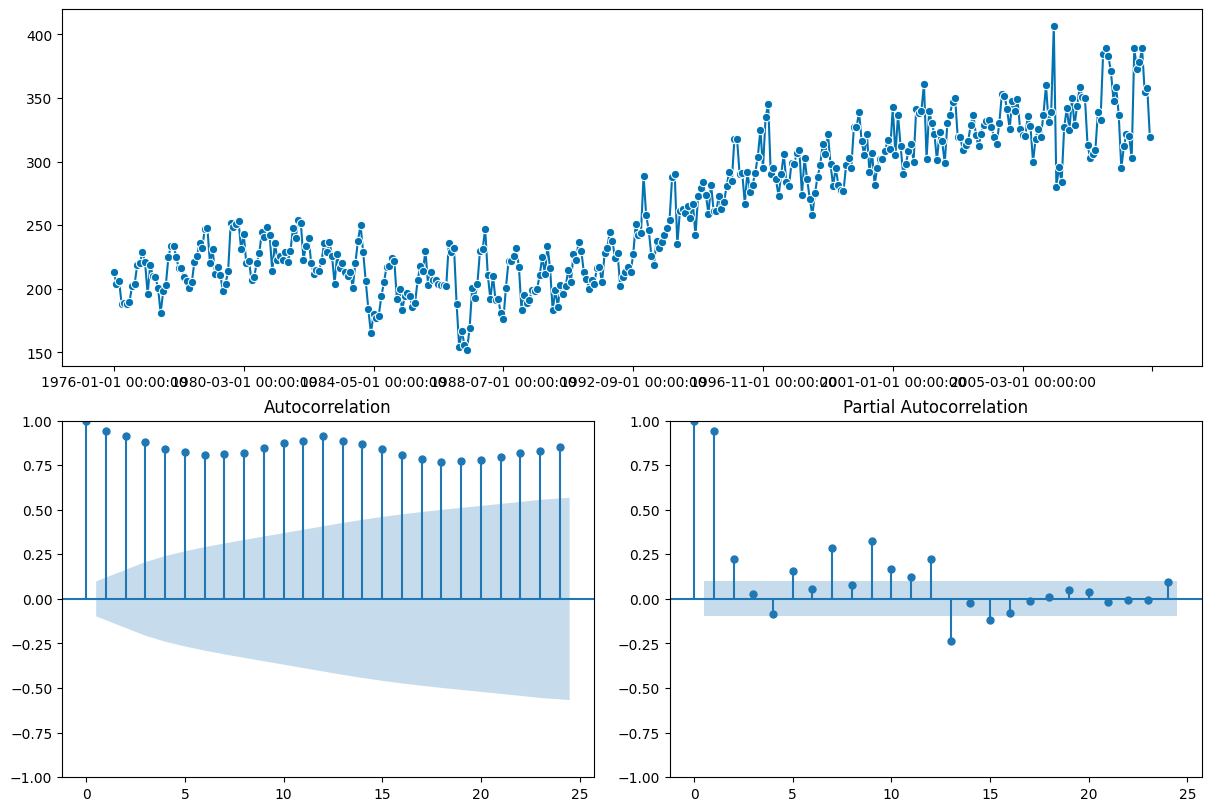

In [3]:
# plots
plot_correlations(energy_ts)

Motivation of 12 month periodicity

- The autocorrelation plot shows a peak at 1 year, which is the periodicity of the data.
- Partial autocorrelation plot shows a peak at 1 year and 2 year, which shows that consecutive years have the highest correlation in temperatures these are indicating that the data has a yearly periodicity
- Ruthermore by observing a data plot, we can see that the data has a yearly periodicity with a peak in the summer and a trough in the winter (This is due to the fact that the data is energy consumption data, which is dependent on temperature, and temperature has a yearly periodicity)

4. [10 points] Separate the trend, seasonal and residual noise components. Display each component separately. Display the residual noise as a scatter plot. From your interpretation of the residual plots, are there are cyclic, trend or seasonal effects which are unaccounted for?
Points breakdown: 3 points for separating the trend, 2 points for displaying each component. 3 points for the scatter plot, histogram plot of the residuals and 2 points for your intepreration.

Text(0, 0.5, 'Frequency')

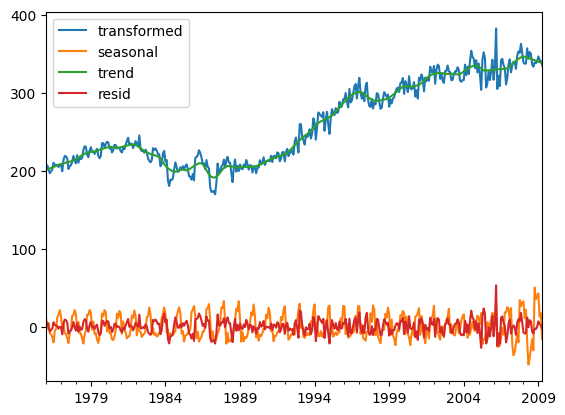

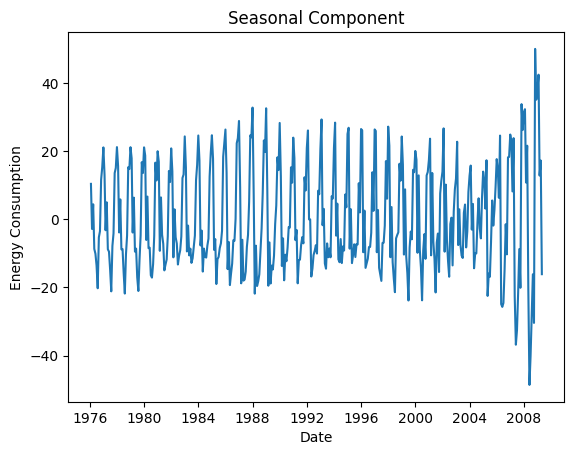

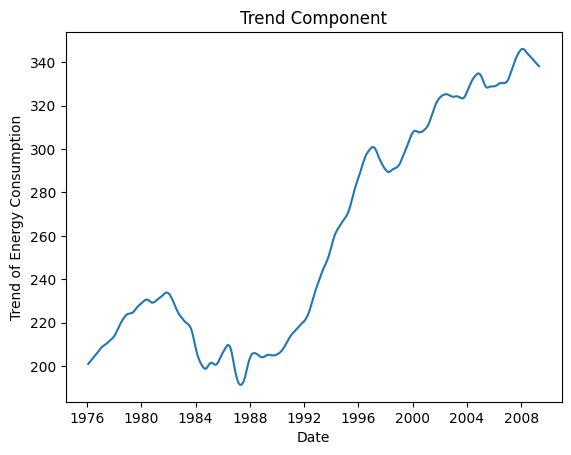

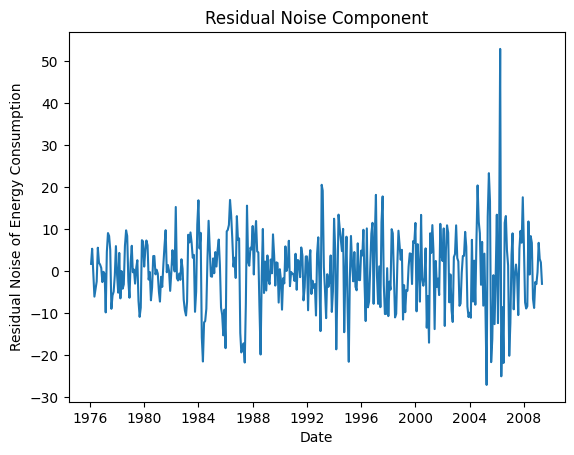

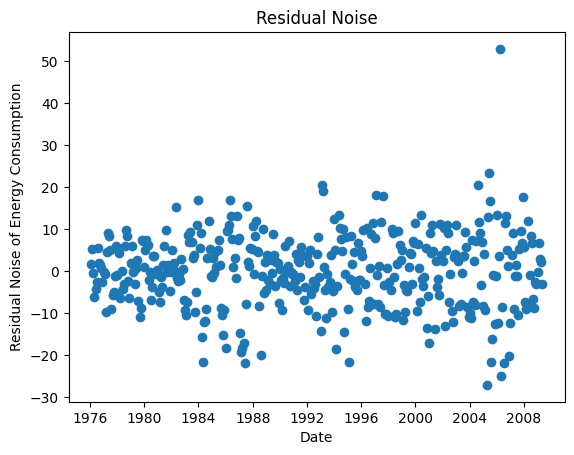

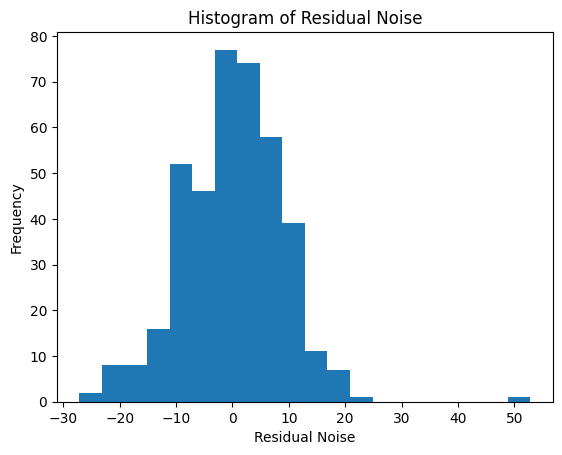

In [8]:
# Separate the trend, seasonal and residual noise components
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=12, return_components=True)
result =  transformer.fit_transform(energy_ts)
result.plot()

# Display each component separately
plt.figure()
plt.plot(result.seasonal)
plt.title("Seasonal Component")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.figure()
plt.plot(result.trend)
plt.title("Trend Component")
plt.xlabel("Date")
plt.ylabel("Trend of Energy Consumption")
plt.figure()
plt.plot(result.resid)
plt.title("Residual Noise Component")
plt.xlabel("Date")
plt.ylabel("Residual Noise of Energy Consumption")

# Display residual noise as scatter plot
plt.figure()
plt.scatter(result.index, result.resid)
plt.title("Residual Noise")
plt.xlabel("Date")
plt.ylabel("Residual Noise of Energy Consumption")
# plot a histogram of the residuals
plt.figure()
plt.hist(result.resid, bins=20)
plt.title("Histogram of Residual Noise")
plt.xlabel("Residual Noise")
plt.ylabel("Frequency")

- There is no factors annacounted for in the model, as the residual noise is normally distributed with a mean of 0 and a relatively small standard deviation.

4. [4 points]  This question is on time series forecasting with ARIMA
* Split the time series into a train, validation and test set. Set the forecasting horizon of the validation set to be 60 months and the test set to 60 months (2 points)
* Fit an ARIMA or SARIMA model on the training set. Find the optimal p,d and q values for ARIMA (by evaluating the mean absolute percentage error on the validation set). Chose at least 3 different values for p and 2 different values for d and q. (6 points)
* With the best p,d and q values you found, fit an ARIMA model on the combined train and validation set. Evaluate your model on the test set by computing the mean absolute percentage error.(6 points)
* Display the train, validation, test set and your predicted solution Label your plot. (1 point)

Validation: Best ARIMA(8, 2, 7) mape_error=0.065
Test: ARIMA MAPE=0.059


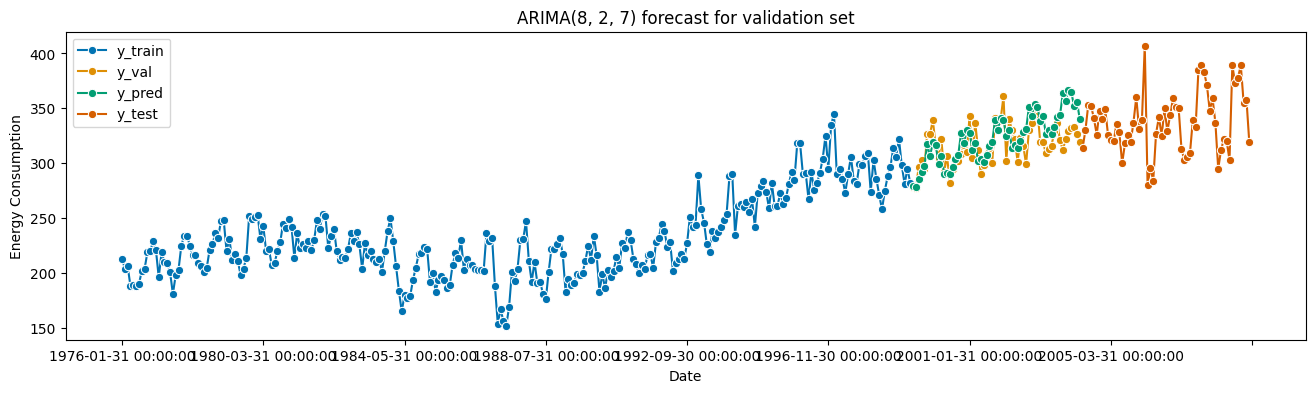

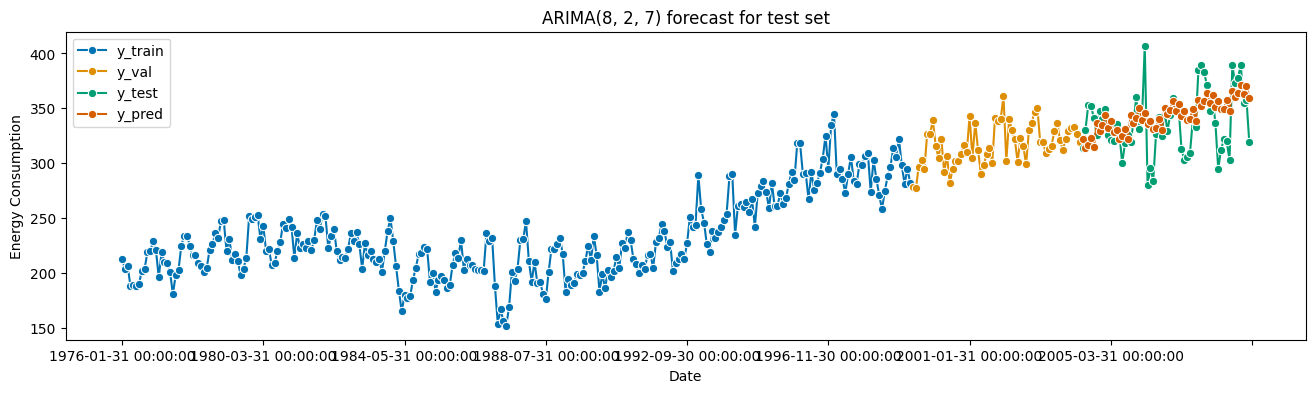

In [5]:
from sktime.forecasting.arima import ARIMA
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series
from sktime.split import temporal_train_test_split
import warnings

warnings.filterwarnings("ignore")

# Resample the time series to month end frequency
energy_ts = energy_ts.resample('M').mean()

# 1
y_train, y_test = temporal_train_test_split(energy_ts, test_size=60)
y_train, y_val = temporal_train_test_split(y_train, test_size=60)
fh = np.arange(1, len(y_test) + 1)

# 2
# Find the optimal p,d and q values for ARIMA (by evaluating the root mean squared error on the validation set).
p_values = [4, 8, 12]
d_values = [0, 1, 2]
q_values = [1, 3, 5, 7, 9]
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            arima_order=(p,d,q)
            try:
                forecaster = ARIMA(order=arima_order, suppress_warnings=True)
                forecaster.fit(y_train)
                y_pred = forecaster.predict(fh=fh)
                mape = MeanAbsolutePercentageError()
                mape_error = mape(y_test, y_pred)
                if mape_error < best_score:
                    best_score, best_cfg = mape_error, arima_order
            except:
                continue

print('Validation: Best ARIMA%s mape_error=%.3f' % (best_cfg, best_score))

# plot the best model
forecaster = ARIMA(order=(8, 2, 7), suppress_warnings=True)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=fh)
plot_series(y_train, y_val, y_pred, y_test, labels=["y_train", "y_val", "y_pred", "y_test"])
# set plot title
plt.title("ARIMA(8, 2, 7) forecast for validation set")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")

# 3
y_trainval = pd.concat([y_train, y_val])
fh = np.arange(1, len(y_test) + 1)
forecaster = ARIMA(order=(8, 2, 7), suppress_warnings=True)
forecaster.fit(y=y_trainval)
y_pred = forecaster.predict(fh=fh)

# 4
plot_series(y_train, y_val, y_test, y_pred, labels=["y_train" , "y_val", "y_test", "y_pred"])
plt.title("ARIMA(8, 2, 7) forecast for test set")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")

# calculate mean absolute percentage error
mape = MeanAbsolutePercentageError()
mape_error = mape(y_test, y_pred)
print('Test: ARIMA MAPE=%.3f' % (mape_error))


5. (7 points) This question is on time series regression with K-Nearest Neighbour using the sklearn or sktime package.
* Split the time series into a train and test set. Set of the test set to 60 month. Using `GridSearchCV`, train a KNN regessor with a 5-fold cross validation. Find the best regularization (nearest neighbour) hyperparameter with 5 different neighbour values. (3 points)
* Using the best hyperparameter found from grid search on the training set, evaluate the mean absolute percentage error on the test set. (When you call grid search.fit, the best hyperparameter is automatically found and stored in grid search). (3 points)
* Display the train, validation, test set and your predicted solution. Label your plot. (1 point)

Best parameters: {'n_neighbors': 3}
Mean Absolute Percentage Error: 1.53%


Text(0, 0.5, 'Energy Consumption')

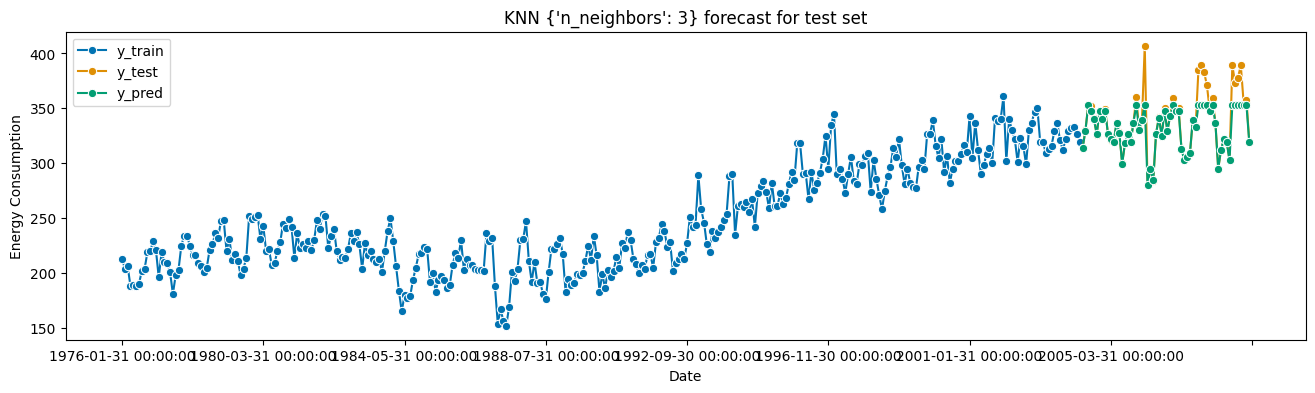

In [6]:
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

y_train, y_test = temporal_train_test_split(energy_ts, test_size=60)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20]
}
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring=mape_scorer)
grid_search.fit(y_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
y_pred = grid_search.best_estimator_.predict(y_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

y_pred = y_pred.flatten()
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Display the train, validation, test set and your predicted solution. Label your plot.
plot_series(y_train, y_test, y_pred_series, labels=["y_train", "y_test", "y_pred"])
plt.title("KNN " + str(best_params) + " forecast for test set")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")

- validation set is not displayed as cross-validation was performed on the training set as instructed

## Alternative attempt (knn with year, month, day as separate features)

Best parameters: {'n_neighbors': 3}
Best score (MAPE): -0.07885075636050903
Mean Absolute Percentage Error: 5.84%


Text(0, 0.5, 'Energy Consumption')

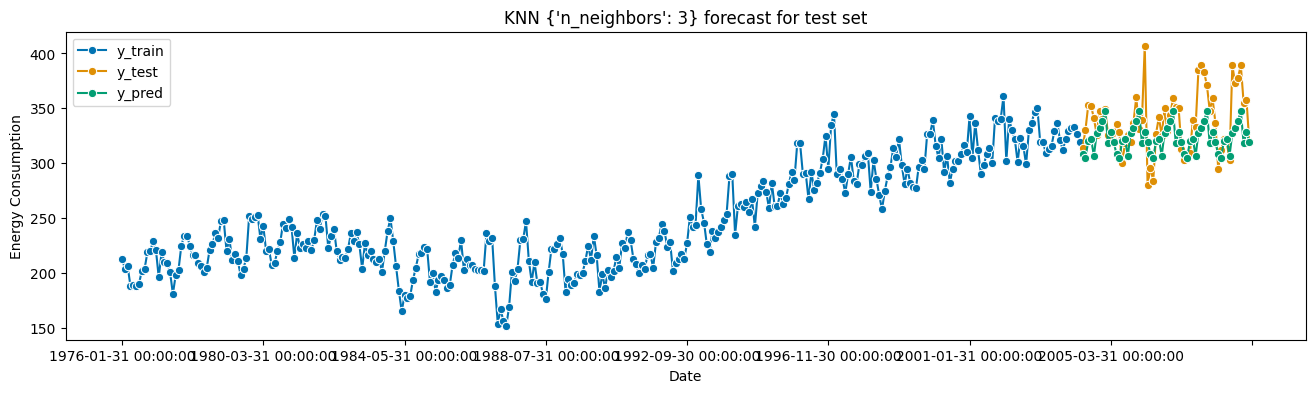

In [7]:
# copy energy_ts to df
df = energy_ts.copy()

# Extract features from the date index
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

"""
Alternative way to extract features from the date index capturing seasonal effects and cyclic behaviour in months and days

# Add cyclic features for month and day to capture seasonal effects
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# scale the features (as a sort of manual feature weight setting)
df['month_sin'] *= 50
df['month_cos'] *= 50
df['day_sin'] *= 0.1
df['day_cos'] *= 0.1

# delete month and day columns
df.drop(columns=['month', 'day'], inplace=True)
"""

# withpout cyclic features
# scale the features (as a sort of manual feature weight setting)
df['day'] *= 0.03
df['month'] *= 10

# split to train and test
y_train, y_test = temporal_train_test_split(df, test_size=60)

# split to target and features, target is "Consumption1"
X_train = y_train.drop(columns=['Consumption1'])
y_train = y_train['Consumption1']
X_test = y_test.drop(columns=['Consumption1'])
y_test = y_test['Consumption1']

# Train the classifier, use euclidean distance as metric, do grid search cv to find the best n_neighbors from 5 n_neighbors params
clf = KNeighborsRegressor(metric='euclidean')
param_grid = {
    'n_neighbors': [i for i in range(20)]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=mape_scorer)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best score (MAPE):", grid_search.best_score_)

# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Display the train, validation, test set and your predicted solution. Label your plot.
y_pred_series = pd.Series(y_pred, index=y_test.index)
plot_series(y_train, y_test, y_pred_series, labels=["y_train", "y_test", "y_pred"])
plt.title("KNN " + str(best_params) + " forecast for test set")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")